# Data Mining 2024 
---
### **Suggested Project:** Predicting weekly passenger numbers on new bus line, and cluster the bus route by usage patterns.
#### **Students:**  Eden Cohen 209056225, Marina Nezhelsky 321859969


---
<a id='section1'></a>
#  1. Prepare The Current Dataset

In this section we will explore the given Dataset, validate the data, handel with missing values and prepare the dataset to the model.

---

## Explore the data, remove duplicate and drop columns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
Dataset = pd.read_csv("Bus Lines 2024.csv")
Dataset.head()

,RouteID,RouteName,RouteDirection,AgencyName,ClusterName,Metropolin,OriginCityName,DestinationCityName,RouteType,ServiceType,...,Saturday - 00:00-03:59,Saturday - 04:00-05:59,Saturday - 06:00-08:59,Saturday - 09:00-11:59,Saturday - 12:00-14:59,Saturday - 15:00-18:59,Saturday - 19:00-23:59,MaxRidership,year,Q
0,10003,3,1,אגד,חיפה עירוני,מטרופולין חיפה,רכסים,רכסים,עירוני,מקומי מאסף,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,שישי - 06:00-08:59,2024,1
1,10006,6,1,אגד,חיפה עירוני,מטרופולין חיפה,חיפה,חיפה,עירוני,מקומי מאסף,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ימי חול - 06:00-08:59,2024,1
2,10006,6,3,אגד,חיפה עירוני,מטרופולין חיפה,חיפה,חיפה,עירוני,מקומי מאסף,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ימי חול - 12:00-14:59,2024,1
3,10007,7,1,אגד,חיפה עירוני,מטרופולין חיפה,חיפה,נשר,עירוני,מקומי מאסף,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ימי חול - 06:00-08:59,2024,1
4,10007,7,2,אגד,חיפה עירוני,מטרופולין חיפה,נשר,חיפה,עירוני,מקומי מאסף,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ימי חול - 15:00-18:59,2024,1


In [3]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10678 entries, 0 to 10677
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RouteID                      10678 non-null  int64  
 1   RouteName                    10678 non-null  int64  
 2   RouteDirection               10678 non-null  int64  
 3   AgencyName                   10678 non-null  object 
 4   ClusterName                  10678 non-null  object 
 5   Metropolin                   10678 non-null  object 
 6   OriginCityName               10678 non-null  object 
 7   DestinationCityName          10678 non-null  object 
 8   RouteType                    10678 non-null  object 
 9   ServiceType                  10678 non-null  object 
 10  RouteParticular              10678 non-null  object 
 11  BusType                      10678 non-null  object 
 12  BusSize                      10678 non-null  object 
 13  NumOfAlternative

# Feuture Engginiering

We want to filter the features that has similarity with the target column (Metropolin) that we want to classify.    
We choose to use Cramers v test, and filter the features that Cramer's V < 0.5.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Define function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Choosing columns type 'object' for Cramer's V calculations
categorical_columns = Dataset.select_dtypes(include=['object']).columns.tolist()
similar_columns = [] #List of the similar columns
for col in categorical_columns:
    if col != "Metropolin":
        cramer_v_value = cramers_v(Dataset["Metropolin"], Dataset[col])
        if cramer_v_value > 0.5:
            similar_columns.append(col)

# Print the columns similar to 'Metropolin'
print("Columns similar to 'Metropolin' with Cramer's V > 0.5:", similar_columns)

# Dropping the similar columns from the dataset
filtered_data = Dataset.drop(columns=similar_columns)

Columns similar to 'Metropolin' with Cramer's V > 0.5: ['AgencyName', 'ClusterName', 'OriginCityName', 'DestinationCityName', 'UniqueLocations']


In [5]:
data = filtered_data.copy()

# Drop unnecessary columns: We will remove those numeric columns, which were not taken in the Cramer test.
# These are key columns that are unique to each row, and therefore do not contribute to the classification.
data = data.loc[:, ~data.columns.str.contains('RouteID|RouteName')] 

# Filling missing values
data = data.dropna(subset=['BusType'])
data = data.dropna(subset=['AVGPassengersPerWeek'])
data = data.dropna(subset=['OperatingCostPerPassenger'])

# Change types
cols_to_update = data.columns[data.columns.str.contains('WorkDay|Saturday|Friday|UniqueStations')]
data[cols_to_update] = data[cols_to_update].notnull().astype(int)

# Drop rows where 'RouteParticular' contains any of the substrings Bus Size is 'לא מוגדר'
data = data[~data['BusSize'].str.contains('לא מוגדר')]

# Replace values
data['BusType'] = data['BusType'].replace(['בינעירוני ממוגן אבן','בינעירוני ממוגן ירי'], ['בינעירוני','בינעירוני'])

# Add new columns for classification
data['OperatingCostPerRide'] = data['OperatingCostPerPassenger'] * data['WeeklyPassengers'] / data['WeekyRides']
data['AVGdistanceBetweenStations'] = data['RouteLength'] / data['StationsInRoute']

#handling the hebrew values in the target column - Metropolin:
translations = {
    'מטרופולין חיפה': 'Haifa Metropolin',
    'מרכז': 'Central',
    'גולן גליל ועמקים': 'Golan, Galilee, and Valleys',
    'י-ם': 'Jerusalem',
    'גוש דן': 'Gush Dan',
    'בין מחוזי': 'Between Districts',
    'מזרח ירושלים': 'East Jerusalem',
    'הדרום': 'The South'
}

# Replace the values in the Metropolin column
data['Metropolin'] = data['Metropolin'].replace(translations)

print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10631 entries, 0 to 10677
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RouteDirection               10631 non-null  int64  
 1   Metropolin                   10631 non-null  object 
 2   RouteType                    10631 non-null  object 
 3   ServiceType                  10631 non-null  object 
 4   RouteParticular              10631 non-null  object 
 5   BusType                      10631 non-null  object 
 6   BusSize                      10631 non-null  object 
 7   NumOfAlternatives            10631 non-null  int64  
 8   RouteLength                  10631 non-null  float64
 9   WeeklyKM                     10631 non-null  float64
 10  AVGPassengersPerWeek         10631 non-null  float64
 11  StationsInRoute              10631 non-null  int64  
 12  OperationSince               10631 non-null  object 
 13  UniqueStations  

,RouteDirection,Metropolin,RouteType,ServiceType,RouteParticular,BusType,BusSize,NumOfAlternatives,RouteLength,WeeklyKM,...,Saturday - 06:00-08:59,Saturday - 09:00-11:59,Saturday - 12:00-14:59,Saturday - 15:00-18:59,Saturday - 19:00-23:59,MaxRidership,year,Q,OperatingCostPerRide,AVGdistanceBetweenStations
0,1,Haifa Metropolin,עירוני,מקומי מאסף,תלמידים,עירוני,אוטובוס,1,3.3,39.7,...,0,0,0,0,0,שישי - 06:00-08:59,2024,1,74.480000,0.275000
1,1,Haifa Metropolin,עירוני,מקומי מאסף,תלמידים,עירוני,אוטובוס,1,8.4,84.2,...,0,0,0,0,0,ימי חול - 06:00-08:59,2024,1,282.678700,0.400000
2,3,Haifa Metropolin,עירוני,מקומי מאסף,סדיר,עירוני,מיניבוס,1,12.3,1317.3,...,0,0,0,0,0,ימי חול - 12:00-14:59,2024,1,300.604112,0.361765
3,1,Haifa Metropolin,עירוני,מקומי מאסף,סדיר,עירוני,אוטובוס,1,4.7,288.9,...,0,0,0,0,0,ימי חול - 06:00-08:59,2024,1,71.315541,0.587500
4,2,Haifa Metropolin,עירוני,מקומי מאסף,סדיר,עירוני,אוטובוס,1,3.7,229.3,...,0,0,0,0,0,ימי חול - 15:00-18:59,2024,1,104.688952,0.462500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10673,2,The South,עירוני,מקומי מאסף,סדיר,עירוני,אוטובוס,1,15.2,4477.8,...,0,0,0,0,1,ימי חול - 12:00-14:59,2024,2,228.115912,0.380000
10674,1,Gush Dan,עירוני,מקומי מאסף,סדיר,עירוני,אוטובוס,1,20.1,8503.3,...,0,0,0,0,1,שישי - 12:00-14:59,2024,2,468.809009,0.394118
10675,2,Gush Dan,עירוני,מקומי מאסף,סדיר,עירוני,אוטובוס,1,19.6,8416.0,...,0,0,0,0,1,שישי - 04:00-05:59,2024,2,451.100614,0.384314
10676,1,"Golan, Galilee, and Valleys",עירוני,מקומי מאסף,סדיר,עירוני,אוטובוס,1,16.9,5202.4,...,0,0,0,0,1,ימי חול - 12:00-14:59,2024,2,265.856013,0.412195


# Encoding

In [6]:
df = data.copy()

from sklearn.preprocessing import LabelEncoder

# create a dictionary that maps the metropolin with the encoding value 
unique_metropolin = df['Metropolin'].unique()
step = 1
encoding = {metro: (i+1) * step for i, metro in enumerate(unique_metropolin)}

# Apply encoding
df['Metropolin_Numeric'] = df['Metropolin'].map(encoding)

numeric_to_metropolin = df[['Metropolin', 'Metropolin_Numeric']].drop_duplicates().set_index('Metropolin_Numeric')['Metropolin'].to_dict()
print(numeric_to_metropolin)

{1: 'Haifa Metropolin', 2: 'Central', 3: 'Golan, Galilee, and Valleys', 4: 'Jerusalem', 5: 'Gush Dan', 6: 'Between Districts', 7: 'East Jerusalem', 8: 'The South'}


In [7]:
#Frecuancy encoding
df['OperationSince'] = df['OperationSince'].map(df['OperationSince'].value_counts())

# Label Encoding 
df['MaxRidership'] = df['MaxRidership'].astype('category')
df['MaxRidership'] = df['MaxRidership'].cat.codes  

# One hot Encoding
df = pd.get_dummies(df, columns=['RouteParticular'])
df = pd.get_dummies(df, columns=['BusType'])
df = pd.get_dummies(df, columns=['BusSize'])
df = pd.get_dummies(df, columns=['RouteType'])
df = pd.get_dummies(df, columns=['ServiceType'])

# Drop original columns after encoding
df = df.drop(columns=['Metropolin'])

df

,RouteDirection,NumOfAlternatives,RouteLength,WeeklyKM,AVGPassengersPerWeek,StationsInRoute,OperationSince,UniqueStations,AverageSpeed,AverageTripDuration,...,BusSize_מפרקי,RouteType_אזורי,RouteType_בינעירוני,RouteType_עירוני,ServiceType_ישיר,ServiceType_מאסף,ServiceType_מהיר,ServiceType_מקומי מאסף,ServiceType_עירוני עורקי מאסף,ServiceType_עירוני עורקי מהיר
0,1,1,3.3,39.7,15.3,12,10146,0,15.99,12.38,...,0,0,0,1,0,0,0,1,0,0
1,1,1,8.4,84.2,2.3,21,10146,1,10.70,47.10,...,0,0,0,1,0,0,0,1,0,0
2,3,1,12.3,1317.3,0.6,34,10146,1,14.73,50.10,...,0,0,0,1,0,0,0,1,0,0
3,1,1,4.7,288.9,1.6,8,10146,0,23.73,11.88,...,0,0,0,1,0,0,0,1,0,0
4,2,1,3.7,229.3,1.6,8,10146,0,12.72,17.45,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10673,2,1,15.2,4477.8,1.3,40,10146,1,23.98,38.03,...,0,0,0,1,0,0,0,1,0,0
10674,1,1,20.1,8503.3,2.0,51,10146,1,15.44,78.11,...,0,0,0,1,0,0,0,1,0,0
10675,2,1,19.6,8416.0,1.9,51,10146,1,15.64,75.19,...,0,0,0,1,0,0,0,1,0,0
10676,1,1,16.9,5202.4,1.2,41,10146,1,22.88,44.32,...,0,0,0,1,0,0,0,1,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10631 entries, 0 to 10677
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RouteDirection                 10631 non-null  int64  
 1   NumOfAlternatives              10631 non-null  int64  
 2   RouteLength                    10631 non-null  float64
 3   WeeklyKM                       10631 non-null  float64
 4   AVGPassengersPerWeek           10631 non-null  float64
 5   StationsInRoute                10631 non-null  int64  
 6   OperationSince                 10631 non-null  int64  
 7   UniqueStations                 10631 non-null  int32  
 8   AverageSpeed                   10631 non-null  float64
 9   AverageTripDuration            10631 non-null  float64
 10  OperatingCostPerPassenger      10631 non-null  float64
 11  DailyRides(Tuesday)            10631 non-null  int64  
 12  WeekyRides                     10631 non-null 

# Feature Selection

## Feature Importance Analysis
We used mutual information for feature selection because it measures the dependency between features and the target variable, capturing both linear and non-linear relationships. This helps identify the most informative features, improving model performance and reducing irrelevant noise.

Top 10 features based on mutual information:
AVGdistanceBetweenStations    0.529447
RouteLength                   0.402145
dtype: float64


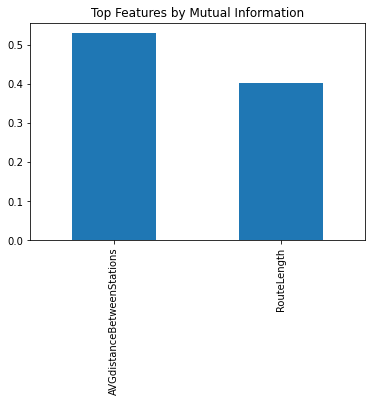

In [9]:
from sklearn.feature_selection import mutual_info_classif
X = df.drop(columns=['Metropolin_Numeric'])  
y = df['Metropolin_Numeric'] 

# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
top_mi_features = mi_scores[mi_scores > 0.4]

# Display top features and plot
print("Top 10 features based on mutual information:")
print(top_mi_features)
top_mi_features.plot(kind='bar', figsize=(6, 4), title='Top Features by Mutual Information')
plt.show()

## Pearson correlation
We used Pearson correlation to measure the linear relationship between two continuous variables, providing insight into the strength and direction of their association. 

Features with correlation higher than 0.2 with 'Metropolin':
['RouteLength', 'AverageSpeed']


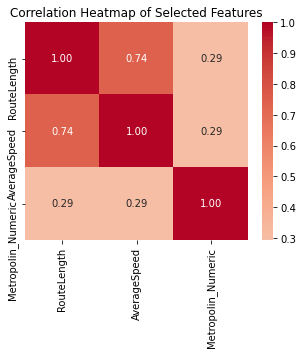

In [10]:
# Compute the correlation matrix
corr_matrix = df.corr()

corr_with_metropolin = corr_matrix['Metropolin_Numeric']

# Filter features where correlation is higher than 0.2 and not equal to 1, and lower than -0.25
high_corr_features = corr_with_metropolin[((corr_with_metropolin > 0.25) | (corr_with_metropolin < -0.25) )& (corr_with_metropolin != 1)]
feature_list = high_corr_features.index.tolist()
print("Features with correlation higher than 0.2 with 'Metropolin':")
print(feature_list)

# Include 'Metropolin_Numeric' in the feature list for the heatmap
full_feature_list=feature_list.copy()
full_feature_list.append('Metropolin_Numeric')
filtered_corr_matrix = df[full_feature_list].corr()

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(filtered_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [11]:
# Combine the top MI and high correlation features, avoiding duplicates
mi_feature_list = top_mi_features.index.tolist()
corr_feature_list = high_corr_features.index.tolist()
feature_list = list(set(mi_feature_list + corr_feature_list))
print("Selected features (based on MI and correlation):")
print(feature_list)

Selected features (based on MI and correlation):
['AVGdistanceBetweenStations', 'AverageSpeed', 'RouteLength']


## Classification Models

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Separating features and target variable
X = df[feature_list]
y = df['Metropolin_Numeric']  #'Metropolin' is the column with classification labels

# Define Scalers for different models
scalers = {
    'RandomForest': StandardScaler(),  # RandomForest does not need scaling
    'LogisticRegression': StandardScaler(),  # Logistic Regression works well with StandardScaler
    'SVC': StandardScaler(),  # SVC is sensitive to the scale of the data, use StandardScaler
    'GradientBoosting': StandardScaler(),  # Gradient Boosting does not strictly require scaling, but StandardScaler can still help
    'KNN': MinMaxScaler()  # KNN works better with MinMaxScaler, as it's sensitive to distance
} 
# Preprocessing pipeline for scaling (no need for imputation since all data is numeric)
# Apply different scalers based on the model
best_score = 0
best_model_name = ""
best_model = None

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
     'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
     'SVC': SVC(random_state=42),
     'GradientBoosting': GradientBoostingClassifier(random_state=42),
     'KNN': KNeighborsClassifier()
}

for model_name, model in models.items():
    # Select the scaler based on the model
    scaler = scalers.get(model_name, StandardScaler())  # Default to StandardScaler if no specific scaler is found
    
    # Define the numeric transformer with the selected scaler
    numeric_transformer = Pipeline(steps=[('scaler', scaler)])

    # Apply the preprocessing pipeline to features
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, feature_list)])  # Use 'feature_list' for your numeric features

    # Define the model pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluation - Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Evaluate the model using cross-validation
    score = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy').mean()
    print(f"Cross-Validation Accuracy: {round(score, 3)}\n")

    if score > best_score:
        best_score = score
        best_model_name = model_name
        best_model = pipeline

print(f"Best Model: {best_model_name} with Accuracy: {round(best_score, 3)}")

# Use the best model for final evaluation
y_pred_best = best_model.predict(X_test)
print(f"Classification Report for Best Model ({best_model_name}):")
print(classification_report(y_test, y_pred_best, zero_division=0))

Model: RandomForest
              precision    recall  f1-score   support

           1       0.63      0.58      0.61       254
           2       0.66      0.67      0.67       413
           3       0.61      0.61      0.61       413
           4       0.66      0.70      0.68       463
           5       0.74      0.71      0.72       235
           6       0.78      0.77      0.78       102
           7       0.82      0.60      0.69        15
           8       0.69      0.71      0.70       232

    accuracy                           0.67      2127
   macro avg       0.70      0.67      0.68      2127
weighted avg       0.67      0.67      0.67      2127

Cross-Validation Accuracy: 0.727

Model: LogisticRegression
              precision    recall  f1-score   support

           1       0.13      0.01      0.01       254
           2       0.22      0.27      0.24       413
           3       0.29      0.29      0.29       413
           4       0.28      0.39      0.33       46

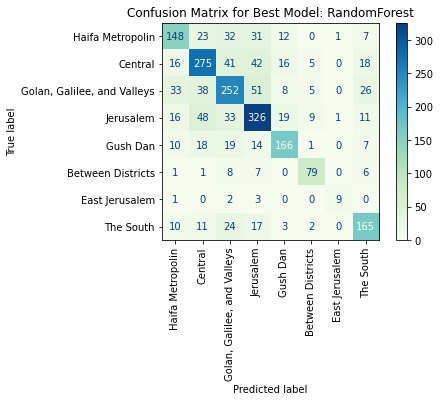

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions using the best model
y_pred_best = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# Remap numeric labels to original labels
# Ensure you use the unique labels that appear in your test data and predictions
unique_labels = np.unique(np.concatenate((y_test, y_pred_best)))
original_labels = [numeric_to_metropolin[label] for label in unique_labels]

# Display the Confusion Matrix with original labels
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_labels)

# Plot Confusion Matrix
cm_display.plot(cmap='GnBu')
plt.title(f'Confusion Matrix for Best Model: {best_model_name}')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.show()

-----
# Un-Supervised
In this section, we will only address the Dan metropolitan area, and attempt to classify it into different clusters with similar characteristics.

In [14]:
row_counts = data.groupby('Metropolin').size()
print(row_counts)

Metropolin
Between Districts               548
Central                        2019
East Jerusalem                   81
Golan, Galilee, and Valleys    2054
Gush Dan                       1164
Haifa Metropolin               1261
Jerusalem                      2263
The South                      1241
dtype: int64


In [15]:
Gush_Dan_df=df[df['Metropolin_Numeric'] == 5]
Gush_Dan_df = Gush_Dan_df.select_dtypes(include=[np.number])
Gush_Dan_df

,RouteDirection,NumOfAlternatives,RouteLength,WeeklyKM,AVGPassengersPerWeek,StationsInRoute,OperationSince,UniqueStations,AverageSpeed,AverageTripDuration,...,BusSize_מפרקי,RouteType_אזורי,RouteType_בינעירוני,RouteType_עירוני,ServiceType_ישיר,ServiceType_מאסף,ServiceType_מהיר,ServiceType_מקומי מאסף,ServiceType_עירוני עורקי מאסף,ServiceType_עירוני עורקי מהיר
150,1,1,23.6,1842.7,0.8,49,10146,0,19.76,71.66,...,0,0,0,1,0,0,0,1,0,0
151,2,1,22.9,1716.1,1.0,49,10146,0,16.24,84.61,...,0,0,0,1,0,0,0,1,0,0
152,1,2,23.7,2159.1,0.9,51,10146,0,21.76,65.35,...,0,0,0,1,0,0,0,1,0,0
153,2,2,25.0,2330.1,0.8,50,10146,0,22.81,65.76,...,0,0,0,1,0,0,0,1,0,0
154,1,1,20.7,2609.8,1.8,42,10146,0,16.41,75.69,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10661,2,1,10.9,3394.6,3.6,27,10146,0,13.45,48.62,...,0,0,0,1,0,0,0,1,0,0
10670,1,1,12.8,573.8,0.0,28,10146,1,26.42,29.07,...,0,0,0,1,0,0,0,1,0,0
10671,2,1,12.7,572.6,0.0,28,10146,1,25.75,29.59,...,0,0,0,1,0,0,0,1,0,0
10674,1,1,20.1,8503.3,2.0,51,10146,1,15.44,78.11,...,0,0,0,1,0,0,0,1,0,0


# PCA and Feature Selection

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Standardize the numeric data in the DataFrame.
def standardize_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df.select_dtypes(include=[np.number]))
    
#Perform PCA and optionally filter features based on loading threshold.
def perform_pca(X, df_columns, n_components=2, threshold=None):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    loadings = pd.DataFrame(pca.components_.T, 
                            columns=[f'PC{i+1}' for i in range(n_components)], 
                            index=df_columns)
    if threshold is not None:
        high_loading_features = loadings[(loadings.abs() > threshold).any(axis=1)].index
        X = X[:, df_columns.isin(high_loading_features)]
        return perform_pca(X, high_loading_features, n_components, threshold=None)
    return pca, loadings, pca.explained_variance_ratio_, X_pca

## function that visuals the loading on each component. 
def visualize_pca_loadings(loadings, explained_variance, title='Feature Loadings on Principal Components'):
    plt.figure(figsize=(30,1))
    sns.heatmap(loadings.T, annot=True, cmap='viridis', cbar=True, linewidths=.5)
    plt.ylabel('Principal Components')
    plt.xlabel('Features')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

#### PCA 

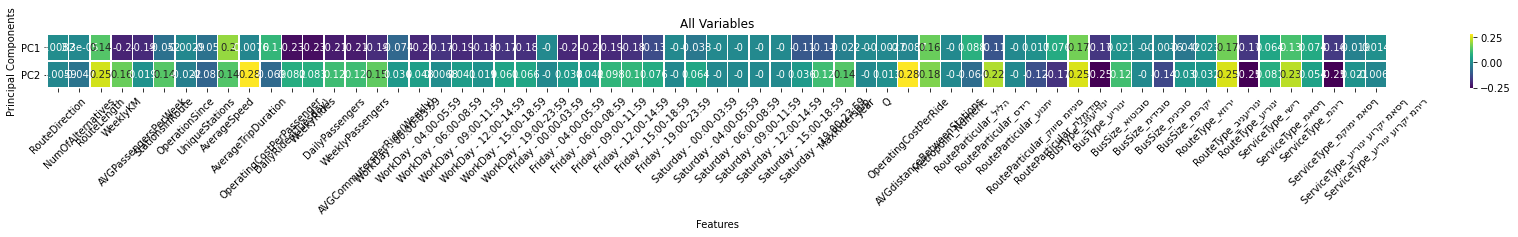

In [17]:
# Standardize the data
X = standardize_data(Gush_Dan_df)

# Perform PCA and visualize all variables
pca, loadings, explained_variance, X_pca = perform_pca(X, Gush_Dan_df.columns)
visualize_pca_loadings(loadings, explained_variance, title='All Variables')

#### PCA with Treshold

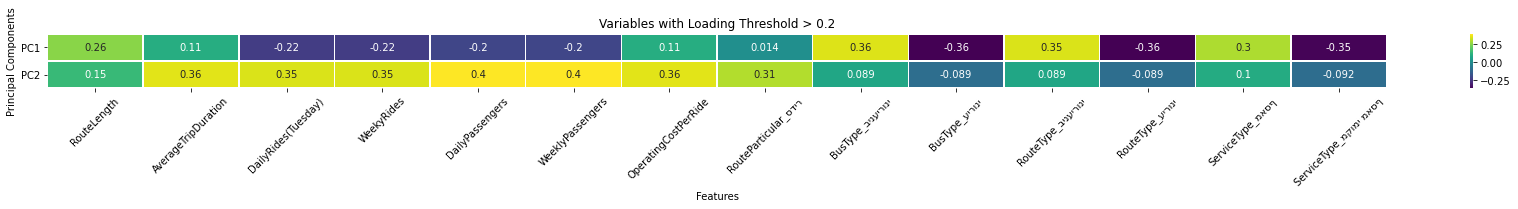

In [18]:
# Perform PCA and visualize variables with threshold of 0.2
pca_threshold,  important_features, explained_variance_threshold, X_pca_threshold = perform_pca(X, Gush_Dan_df.columns, threshold=0.21)
visualize_pca_loadings( important_features, explained_variance_threshold, title='Variables with Loading Threshold > 0.2')

In [19]:
#list of the important feature names
important_feature_names = important_features.index.tolist()
important_feature_names

['RouteLength',
 'AverageTripDuration',
 'DailyRides(Tuesday)',
 'WeekyRides',
 'DailyPassengers',
 'WeeklyPassengers',
 'OperatingCostPerRide',
 'RouteParticular_סדיר',
 'BusType_בינעירוני',
 'BusType_עירוני',
 'RouteType_בינעירוני',
 'RouteType_עירוני',
 'ServiceType_מאסף',
 'ServiceType_מקומי מאסף']

In [20]:
#Data Frame with the important features + standardize the data
Gush_Dan_important_df = Gush_Dan_df[important_feature_names]
X_important_scaled = standardize_data(Gush_Dan_important_df)

# Kmeans experimants 

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Function that determines the optimal number of clusters using Elbow and Silhouette methods.
def determine_optimal_clusters(X):
    wss = []
    silhouette_scores = []
    K = range(1, 11) #Loop over different cluster numbers 1 to 10
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wss.append(kmeans.inertia_)
        if k > 1: #if k>1 (since silhouette score is not defined for a single cluster)
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
            
    #Determine optimal k using the Elbow Method
    second_derivative = np.diff(np.diff(wss))
    optimal_k_elbow = np.argmax(second_derivative) + 2
    
    #Determine optimal k using the Silhouette Method
    optimal_k_silhouette = np.argmax(silhouette_scores) + 2
    
    return optimal_k_elbow, optimal_k_silhouette, wss, silhouette_scores

#Function that visualize the clustering results
def visualize_clusters(X_pca, kmeans_elbow, kmeans_silhouette, wss, silhouette_scores, optimal_k_elbow, optimal_k_silhouette):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot Elbow Method
    axes[0, 0].plot(range(1, 11), wss, 'bo-')
    axes[0, 0].plot(optimal_k_elbow, wss[optimal_k_elbow - 1], 'ro')  # Mark the optimal point in red
    axes[0, 0].set_title('Elbow Method')
    axes[0, 0].set_xlabel('Number of clusters (k)')
    axes[0, 0].set_ylabel('WSS')

    # K-Means Clustering with optimal k from Elbow Method
    axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_elbow.labels_, cmap='viridis')
    axes[0, 1].set_title(f'K-Means Clustering (k={optimal_k_elbow})')
    axes[0, 1].set_xlabel('PCA Component 1')
    axes[0, 1].set_ylabel('PCA Component 2')

    # Plot Silhouette Scores
    axes[1, 0].plot(range(2, 11), silhouette_scores, 'bo-')
    axes[1, 0].plot(optimal_k_silhouette, silhouette_scores[optimal_k_silhouette - 2], 'ro')  # Mark the optimal point in red
    axes[1, 0].set_title('Silhouette Score Method')
    axes[1, 0].set_xlabel('Number of clusters')
    axes[1, 0].set_ylabel('Silhouette Score')

    # K-Means Clustering with optimal k from Silhouette Method
    axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_silhouette.labels_, cmap='viridis')
    axes[1, 1].set_title(f'K-Means Clustering (k={optimal_k_silhouette})')
    axes[1, 1].set_xlabel('PCA Component 1')
    axes[1, 1].set_ylabel('PCA Component 2')

    plt.tight_layout()
    plt.show()

C:\Users\marin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


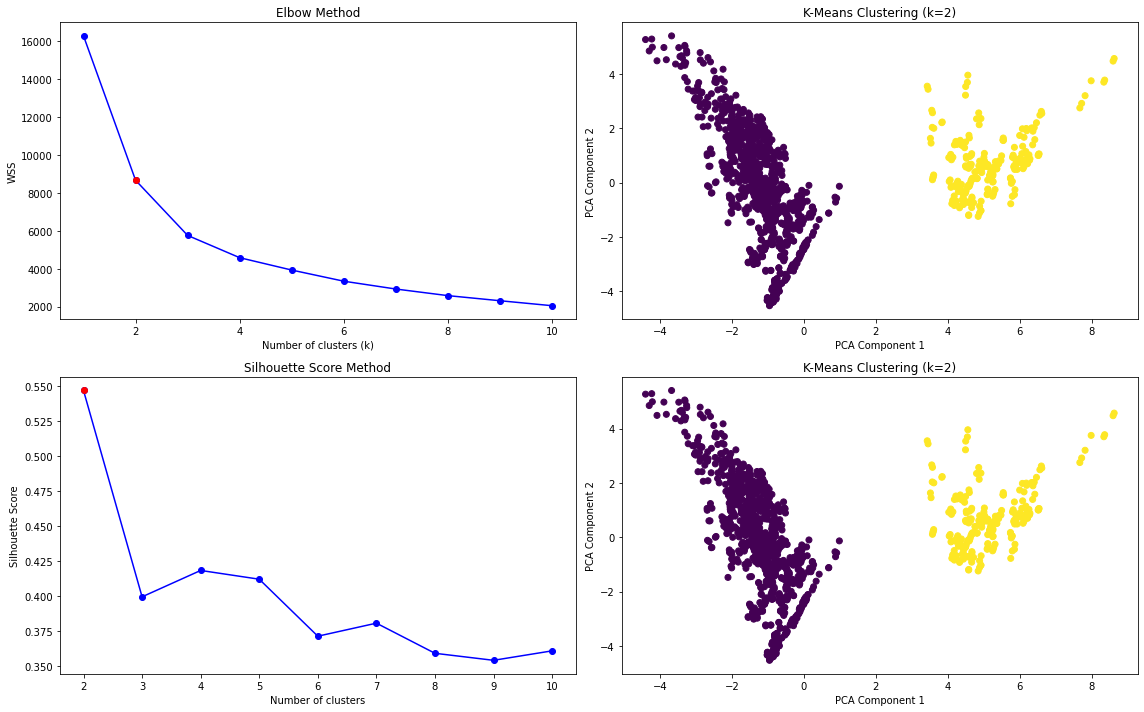

In [22]:
# Determine optimal number of clusters
optimal_k_elbow, optimal_k_silhouette, wss, silhouette_scores = determine_optimal_clusters(X_important_scaled)

# Fit K-Means for optimal clusters
kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=42).fit(X_important_scaled)
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42).fit(X_important_scaled)

# Perform PCA for 2D visualization
X_pca = PCA(n_components=2).fit_transform(X_important_scaled)

# Visualize the clustering results
visualize_clusters(X_pca, kmeans_elbow, kmeans_silhouette, wss, silhouette_scores, optimal_k_elbow, optimal_k_silhouette)

#### Define the clusters
In order to facilitate the characterization of the clusters, we will create a summary table of each cluster.

In [23]:
# Add 'Cluster' column safely using .loc
Gush_Dan_important_df = Gush_Dan_important_df.copy()
Gush_Dan_important_df.loc[:, 'Cluster'] = kmeans_silhouette.labels_

# Create DataFrames for each cluster
cluster_0_df = Gush_Dan_important_df.loc[Gush_Dan_important_df['Cluster'] == 0].drop(columns=['Cluster'])
cluster_1_df = Gush_Dan_important_df.loc[Gush_Dan_important_df['Cluster'] == 1].drop(columns=['Cluster'])

# Generate descriptive statistics for each cluster
cluster_0_stats = cluster_0_df.describe()
cluster_0_stats

,RouteLength,AverageTripDuration,DailyRides(Tuesday),WeekyRides,DailyPassengers,WeeklyPassengers,OperatingCostPerRide,RouteParticular_סדיר,BusType_בינעירוני,BusType_עירוני,RouteType_בינעירוני,RouteType_עירוני,ServiceType_מאסף,ServiceType_מקומי מאסף
count,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.0,937.0,937.0,937.0,937.0,937.000000
mean,17.107044,57.371814,48.867663,271.992529,1507.621985,8261.732764,343.837488,0.846318,0.0,1.0,0.0,1.0,0.0,0.989328
std,6.476090,19.695260,33.069300,185.281943,1488.203483,8248.903752,118.957515,0.360836,0.0,0.0,0.0,0.0,0.0,0.102809
min,3.100000,9.630000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.000000
25%,12.600000,44.860000,23.000000,118.000000,253.000000,1353.100000,269.157778,1.000000,0.0,1.0,0.0,1.0,0.0,1.000000
50%,16.600000,58.990000,49.000000,272.000000,1075.300000,5807.100000,353.983000,1.000000,0.0,1.0,0.0,1.0,0.0,1.000000
75%,21.500000,71.640000,70.000000,386.000000,2421.900000,13214.200000,429.933600,1.000000,0.0,1.0,0.0,1.0,0.0,1.000000
max,49.400000,125.330000,175.000000,1017.000000,7479.700000,42435.200000,751.893333,1.000000,0.0,1.0,0.0,1.0,0.0,1.000000


In [24]:
cluster_1_df.describe()

,RouteLength,AverageTripDuration,DailyRides(Tuesday),WeekyRides,DailyPassengers,WeeklyPassengers,OperatingCostPerRide,RouteParticular_סדיר,BusType_בינעירוני,BusType_עירוני,RouteType_בינעירוני,RouteType_עירוני,ServiceType_מאסף,ServiceType_מקומי מאסף
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.0,227.0,227.000000,227.0,227.000000,227.0
mean,42.720264,71.744141,18.431718,101.550661,337.521586,1840.999119,430.458365,0.955947,1.0,0.0,0.982379,0.0,0.691630,0.0
std,28.729132,22.390228,21.212546,114.851504,541.724533,2947.237532,134.335361,0.205666,0.0,0.0,0.131861,0.0,0.462841,0.0
min,15.300000,32.050000,0.000000,2.000000,0.000000,3.500000,192.291750,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0
25%,25.550000,58.490000,2.000000,17.000000,20.150000,130.250000,350.935581,1.000000,1.0,0.0,1.000000,0.0,0.000000,0.0
50%,31.500000,67.200000,12.000000,60.000000,86.800000,450.500000,403.150000,1.000000,1.0,0.0,1.000000,0.0,1.000000,0.0
75%,51.300000,79.010000,25.500000,149.000000,386.900000,2071.400000,474.018936,1.000000,1.0,0.0,1.000000,0.0,1.000000,0.0
max,167.100000,164.710000,91.000000,523.000000,2765.300000,15422.900000,988.237500,1.000000,1.0,0.0,1.000000,0.0,1.000000,0.0


# Gaussian Mixture Experimants

C:\Users\marin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


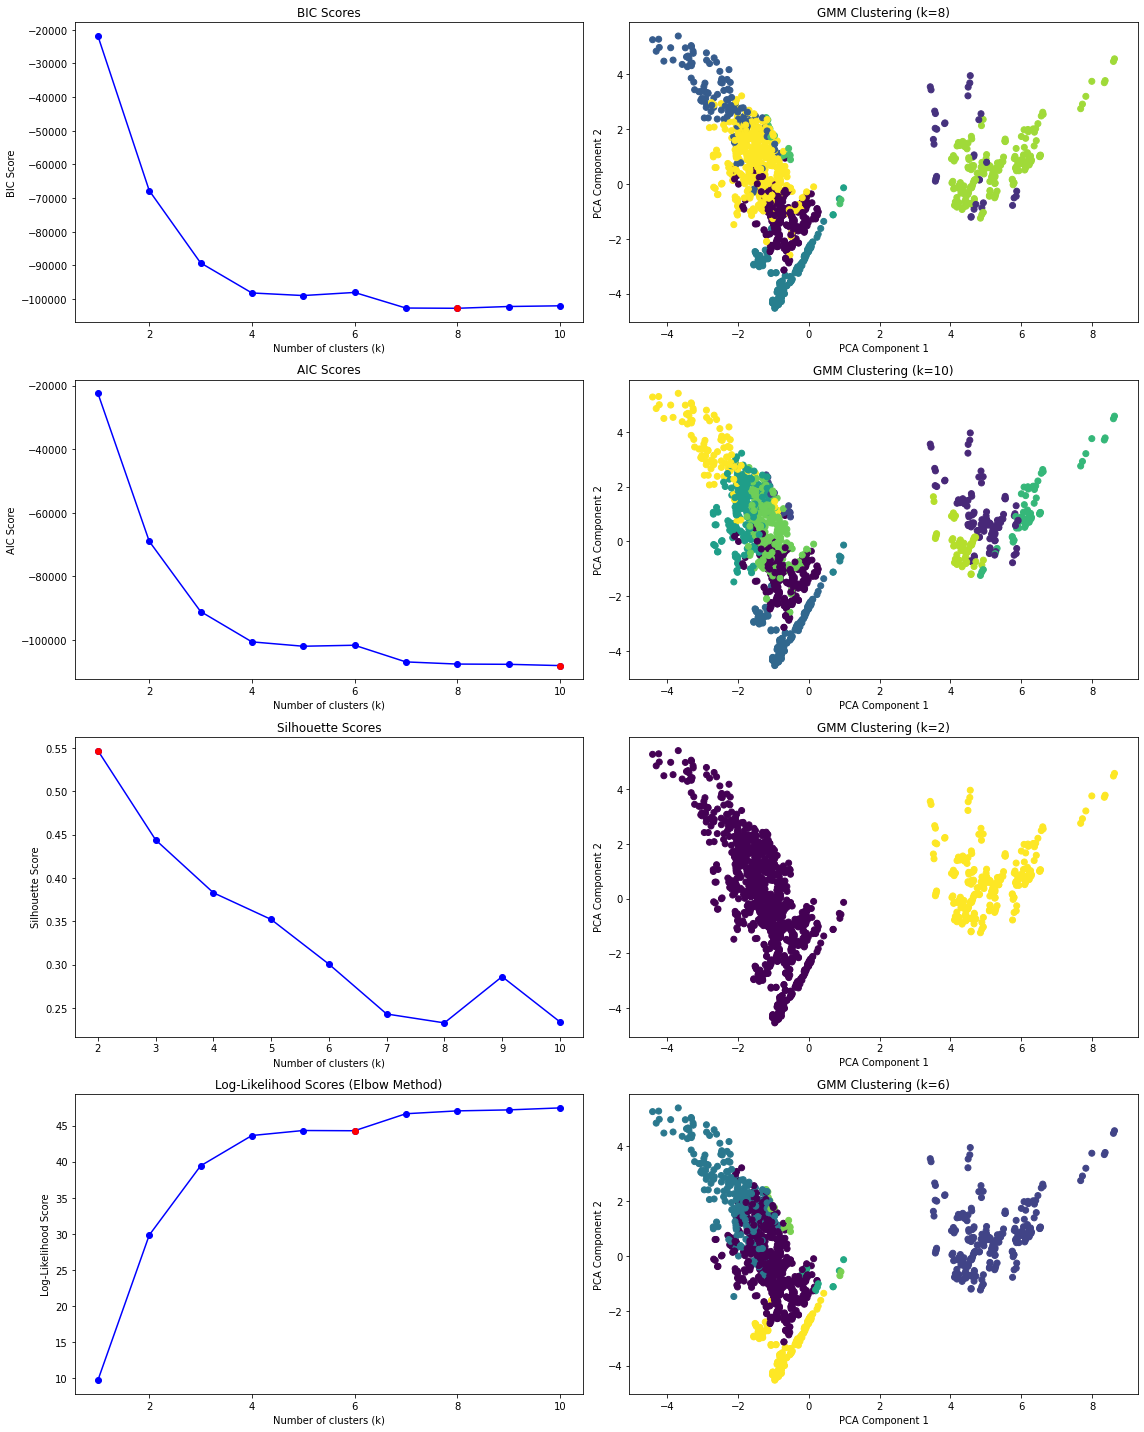

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using BIC, AIC, Silhouette Scores, and Elbow Method
bic_scores = []
aic_scores = []
silhouette_scores = []
log_likelihoods = []

K = range(1, 11)  # Test k values from 1 to 10
for k in K:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_important_scaled)
    bic_scores.append(gmm.bic(X_important_scaled))
    aic_scores.append(gmm.aic(X_important_scaled))
    log_likelihoods.append(gmm.score(X_important_scaled))

    if k > 1:  # Silhouette score is not defined for a single cluster
        labels = gmm.predict(X_important_scaled)
        silhouette_scores.append(silhouette_score(X_important_scaled, labels))
    else:
        silhouette_scores.append(None)  # Placeholder for k=1

optimal_k_bic = np.argmin(bic_scores) + 1  # The best model is the one with the lowest BIC
optimal_k_aic = np.argmin(aic_scores) + 1  # The best model is the one with the lowest AIC
optimal_k_silhouette = np.argmax(silhouette_scores[1:]) + 2  # Ignore k=1 and find max

# Identify the optimal k for Elbow Method adapted for GMM (find the "elbow" point)
# Using the point with the maximum second derivative change
second_derivative = np.diff(np.diff(log_likelihoods))
optimal_k_elbow = np.argmax(second_derivative) + 2  # Adding 2 because of the second derivative

# Fit GMM for each optimal number of clusters
gmm_bic = GaussianMixture(n_components=optimal_k_bic, random_state=42)
gmm_bic.fit(X_important_scaled)
labels_bic = gmm_bic.predict(X_important_scaled)

gmm_aic = GaussianMixture(n_components=optimal_k_aic, random_state=42)
gmm_aic.fit(X_important_scaled)
labels_aic = gmm_aic.predict(X_important_scaled)

gmm_silhouette = GaussianMixture(n_components=optimal_k_silhouette, random_state=42)
gmm_silhouette.fit(X_important_scaled)
labels_silhouette = gmm_silhouette.predict(X_important_scaled)

gmm_elbow = GaussianMixture(n_components=optimal_k_elbow, random_state=42)
gmm_elbow.fit(X_important_scaled)
labels_elbow = gmm_elbow.predict(X_important_scaled)

# Perform PCA for visualization (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_important_scaled)

# Create subplots for comparison
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# Plot BIC scores
axes[0, 0].plot(K, bic_scores, 'bo-')
axes[0, 0].plot(optimal_k_bic, bic_scores[optimal_k_bic - 1], 'ro')  # Mark the optimal point in red
axes[0, 0].set_title('BIC Scores')
axes[0, 0].set_xlabel('Number of clusters (k)')
axes[0, 0].set_ylabel('BIC Score')

axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_bic, cmap='viridis')
axes[0, 1].set_title(f'GMM Clustering (k={optimal_k_bic})')
axes[0, 1].set_xlabel('PCA Component 1')
axes[0, 1].set_ylabel('PCA Component 2')

# Plot AIC scores
axes[1, 0].plot(K, aic_scores, 'bo-')
axes[1, 0].plot(optimal_k_aic, aic_scores[optimal_k_aic - 1], 'ro')  # Mark the optimal point in red
axes[1, 0].set_title('AIC Scores')
axes[1, 0].set_xlabel('Number of clusters (k)')
axes[1, 0].set_ylabel('AIC Score')

axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_aic, cmap='viridis')
axes[1, 1].set_title(f'GMM Clustering (k={optimal_k_aic})')
axes[1, 1].set_xlabel('PCA Component 1')
axes[1, 1].set_ylabel('PCA Component 2')

# Plot Silhouette scores
axes[2, 0].plot(K[1:], silhouette_scores[1:], 'bo-')  # Start from k=2
axes[2, 0].plot(optimal_k_silhouette, silhouette_scores[optimal_k_silhouette - 1], 'ro')  # Mark the optimal point in red
axes[2, 0].set_title('Silhouette Scores')
axes[2, 0].set_xlabel('Number of clusters (k)')
axes[2, 0].set_ylabel('Silhouette Score')

axes[2, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_silhouette, cmap='viridis')
axes[2, 1].set_title(f'GMM Clustering (k={optimal_k_silhouette})')
axes[2, 1].set_xlabel('PCA Component 1')
axes[2, 1].set_ylabel('PCA Component 2')

# Plot Log-Likelihood scores (Elbow Method adapted for GMM)
axes[3, 0].plot(K, log_likelihoods, 'bo-')
axes[3, 0].plot(optimal_k_elbow, log_likelihoods[optimal_k_elbow - 1], 'ro')  # Mark the optimal point in red
axes[3, 0].set_title('Log-Likelihood Scores (Elbow Method)')
axes[3, 0].set_xlabel('Number of clusters (k)')
axes[3, 0].set_ylabel('Log-Likelihood Score')

axes[3, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_elbow, cmap='viridis')
axes[3, 1].set_title(f'GMM Clustering (k={optimal_k_elbow})')
axes[3, 1].set_xlabel('PCA Component 1')
axes[3, 1].set_ylabel('PCA Component 2')

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()